# BAIT 509 Group Project : Mental Health Survey In Tech Companies

In [ ]:
# Import Packages

# For pre-processing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# For building models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#For accessing models 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pre-processing


In [ ]:
# Reading the dataset
df = pd.read_csv('survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29,37,Female,United States,IL,NaN,No,Yes,Often,25-Jun,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29,32,Male,Canada,NaN,NaN,No,No,Rarely,25-Jun,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [ ]:
print("Different age groups: \n")
print(df['Age'].unique())
print("\n \n \n")
print("Different gender notations are: \n")
print(df['Gender'].unique())

Different age groups: 

[         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          38
          50          24          18          28          26          22
          19          25          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72]

 
 

Different gender notations are: 

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 '

In [ ]:
# Fixing the Age and Gender columns
df.drop(df[df['Age'] > 100].index, inplace = True)
df.drop(df[df['Age'] < 15].index, inplace = True)

df['Gender'].replace(['Male ', 'male', 'Man', 'cis male','Male', 'Cis Male',
                      'M', 'm', 'Mail', 'Malr', 'Mal', 'Male (CIS)',
                      'Cis Man', 'msle', 'Male-ish', 'maile', 'Make',], 'Male', inplace = True)

df['Gender'].replace(['Female ', 'female', 'femail', 'Cis Female', 'Woman', 'Female',
                     'F', 'f', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

df['Gender'].replace( ['Female (trans)', 'fluid', 'queer', 'non-binary',
                      'queer/she/they','Androgyne', 'Trans-female', 'male leaning androgynous',
                     'ostensibly male, unsure what that really means',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'Guy (-ish) ^_^', 'Trans woman',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?', ],'Other',inplace = True)

In [ ]:
df.drop(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
        'no_employees', 'seek_help', 'care_options',
        'tech_company',  'leave', 'phys_health_consequence', 'coworkers',
        'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'comments'],axis = 1, inplace = True)

In [ ]:
df.columns

Index(['family_history', 'treatment', 'work_interfere', 'remote_work',
       'benefits', 'wellness_program', 'anonymity',
       'mental_health_consequence', 'supervisor', 'obs_consequence'],
      dtype='object')

In [ ]:
# dropping the null values
df.dropna(inplace = True)

In [ ]:
# Creating a dataframe copy for binning
df_bin = df.copy(deep=True)
df_bin.loc[df_bin['work_interfere'] == "Often", 'work_interfere'] = "Yes"
df_bin.loc[df_bin['work_interfere'] == "Sometimes", 'work_interfere'] = "Yes"
df_bin.loc[df_bin['work_interfere'] == "Rarely", 'work_interfere'] = "No"
df_bin.loc[df_bin['work_interfere'] == "Never", 'work_interfere'] = "No"

In [ ]:
df_bin.dropna(inplace = True)

In [ ]:
# Splitting the dataset before processing to follow The Golden Rule
train_df, test_df = train_test_split(df, test_size=0.25, random_state=130)
X_train = train_df.drop(columns=["work_interfere"])
y_train = train_df["work_interfere"]
X_test = test_df.drop(columns=["work_interfere"])
y_test = test_df["work_interfere"]

In [ ]:
# Splitting for the binned dataset
train_df_bin, test_df_bin = train_test_split(df_bin, test_size=0.25, random_state=77)
X_train_bin = train_df_bin.drop(columns=["work_interfere"])
y_train_bin = train_df_bin["work_interfere"]
X_test_bin = test_df_bin.drop(columns=["work_interfere"])
y_test_bin = test_df_bin["work_interfere"]

In [ ]:
# creating the column tansformer
categorical_features = X_train.select_dtypes('object').columns

In [ ]:
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant",fill_value="missing")),
           ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'))]
)

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Column Transformer for the binned dataset
categorical_features_bin = X_train_bin.select_dtypes('object').columns

categorical_transformer_bin = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant",fill_value="missing")),
           ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'))]
)

col_transformer_bin = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer_bin, categorical_features_bin)
    ],
    remainder='passthrough'
)

#Building Model

In [ ]:

# Create a dummy model for normal label and binary label

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

dummy_bin = DummyClassifier(strategy='most_frequent')
dummy_bin.fit(X_train_bin, y_train_bin)

print("Normal label score: ", dummy.score(X_test, y_test))
print("Binary label score: ", dummy_bin.score(X_test_bin, y_test_bin))

Normal label score:  0.4959677419354839
Binary label score:  0.6129032258064516


In [ ]:

# Create pipelines for hyperparameter optimization

## For normal labels
pipe_sv = Pipeline(
    steps=[('columntransformer', col_transformer),
           ('svc', SVC())]
)

## For binary labels
pipe_sv_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('svc', SVC())]
)

pipe_dt_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('dtc', DecisionTreeClassifier())]
)

Models for Normal Labels

In [ ]:
# Create an SVC model

# set a param
param = {'svc__gamma': [0.01, 0.1, 1, 10, 100, 1000], 'svc__C': [0.01, 0.1, 1, 10, 100, 1000]}

# Set random_search
# model should be changed to pipe
sv_grid = GridSearchCV(pipe_sv, param, cv=10, n_jobs=-1, return_train_score=True)
sv_grid.fit(X_train, y_train)

sv_grid_result = pd.DataFrame(sv_grid.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')

# get best parameter
svc_gamma = sv_grid.best_params_['svc__gamma']
svc_C = sv_grid.best_params_['svc__C']

# Create new pipeline with optimized hyperparameter
svc = Pipeline(
    steps=[('columntransformer', col_transformer),
          ('svc', SVC(gamma=svc_gamma, C=svc_C))]
)

# # Train and test the model
svc.fit(X_train, y_train)
svc_testscore = svc.score(X_test, y_test)
print('SVC test score: ', svc_testscore)

SVC test score:  0.5201612903225806


Model for binary labels

In [ ]:
# Create a decision tree classifier

# Set param_grid
param_grid = {'dtc__min_samples_split': list(range(10, 101))}

# Do gridsearchCV
dt_grid_bin = GridSearchCV(pipe_dt_bin, param_grid, cv=10, n_jobs=-1, return_train_score=True)
dt_grid_bin.fit(X_train_bin, y_train_bin)

dt_grid_bin_result = pd.DataFrame(dt_grid_bin.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')
#dt_grid_result

# get best parameter
hp_min_split_bin = dt_grid_bin.best_params_['dtc__min_samples_split']
#hp_min_split

# Create new pipeline with optimized hyperparameter
dec_tree_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('dtc', DecisionTreeClassifier(min_samples_split=hp_min_split_bin))]
)

# # Train and test the model
dec_tree_bin.fit(X_train_bin, y_train_bin)
dec_tree_bin_testscore = dec_tree_bin.score(X_test_bin, y_test_bin)
print('Dec tree test score: ', dec_tree_bin_testscore)

Dec tree test score:  0.7096774193548387


In [ ]:
# Create an SVC model

# set a param
param = {'svc__gamma': [0.01, 0.1, 1, 10, 100, 1000], 'svc__C': [0.01, 0.1, 1, 10, 100, 1000]}

# Set random_search
# model should be changed to pipe
sv_grid_bin = GridSearchCV(pipe_sv_bin, param, cv=10, n_jobs=-1, return_train_score=True)
sv_grid_bin.fit(X_train_bin, y_train_bin)

sv_grid_bin_result = pd.DataFrame(sv_grid_bin.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')

# get best parameter
svc_gamma_bin = sv_grid_bin.best_params_['svc__gamma']
svc_C_bin = sv_grid_bin.best_params_['svc__C']

# Create new pipeline with optimized hyperparameter
svc_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('svc', SVC(gamma=svc_gamma_bin, C=svc_C_bin))]
)

# # Train and test the model
svc_bin.fit(X_train_bin, y_train_bin)
svc_bin_testscore = svc_bin.score(X_test_bin, y_test_bin)
print('SVC test score: ', svc_bin_testscore)

SVC test score:  0.7096774193548387


## Model Evaluation (test score, f1, recall, precision, etc.) 

### Model Evaluation : SVC

In [ ]:
# confusion matrix to visualize the performance of the algorithm.
predictions_svc = svc.predict(X_test)
cm_svc = confusion_matrix(y_test, predictions_svc)
cm_svc

array([[38,  0,  0,  6],
       [ 4,  0,  0, 34],
       [12,  0,  0, 31],
       [32,  0,  0, 91]])

In [ ]:
#predictions_svc 

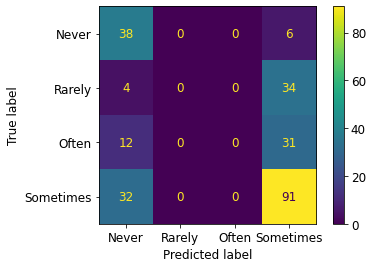

In [ ]:
# Confusion Matrix plot 

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm_svc, display_labels=["Never","Rarely","Often","Sometimes"]).plot()

In [ ]:
# Classification Report  
print(classification_report(
        y_test,
        svc.predict(X_test),digits=4,
        target_names=["Never", "Rarely", "Often","Sometimes"]))

              precision    recall  f1-score   support

       Never     0.4419    0.8636    0.5846        44
      Rarely     0.0000    0.0000    0.0000        38
       Often     0.0000    0.0000    0.0000        43
   Sometimes     0.5617    0.7398    0.6386       123

    accuracy                         0.5202       248
   macro avg     0.2509    0.4009    0.3058       248
weighted avg     0.3570    0.5202    0.4204       248



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Check for classification balance
y_train.value_counts('work_interfere')

Sometimes    0.460189
Never        0.226721
Rarely       0.175439
Often        0.137652
Name: work_interfere, dtype: float64

### Model Evaluation : Dec Tree Bin

In [ ]:
# confusion matrix to visualize the performance of the algorithm.
predictions_dt = dec_tree_bin.predict(X_test_bin)
cm_dt = confusion_matrix(y_test_bin, predictions_dt)
cm_dt

array([[ 46,  50],
       [ 22, 130]])

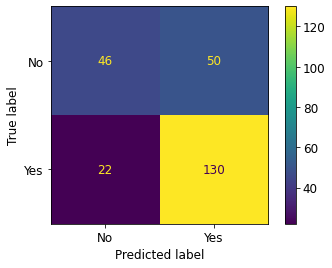

In [ ]:
# Confusion Matrix plot 

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm_dt, display_labels=["No", "Yes"]).plot()

In [ ]:
# Classification Report  - Dec Tree Model
print(classification_report(
        y_test_bin,
        dec_tree_bin.predict(X_test_bin),digits=4,
        target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No     0.6765    0.4792    0.5610        96
         Yes     0.7222    0.8553    0.7831       152

    accuracy                         0.7097       248
   macro avg     0.6993    0.6672    0.6721       248
weighted avg     0.7045    0.7097    0.6971       248



### Model Evaluation : SVC_bin

In [ ]:
# confusion matrix on SVC_bin to visualize the performance of the algorithm.svc_bin.fit(X_train_bin, y_train_bin)
predictions = svc_bin.predict(X_test_bin)
cm = confusion_matrix(y_test_bin, predictions)
cm

array([[ 46,  50],
       [ 22, 130]])

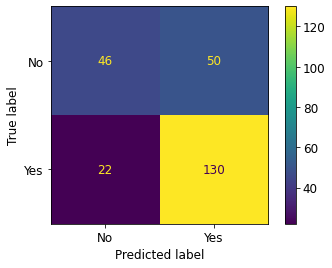

In [ ]:
# Confusion Matrix plot SVC_bin

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"]).plot()

In [ ]:
# Classification Report  - SVC_bin Model
print(classification_report(
        y_test_bin,
        svc_bin.predict(X_test_bin),digits=4,
        target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No     0.6765    0.4792    0.5610        96
         Yes     0.7222    0.8553    0.7831       152

    accuracy                         0.7097       248
   macro avg     0.6993    0.6672    0.6721       248
weighted avg     0.7045    0.7097    0.6971       248



In [ ]:
# Check for classification balance
y_train_bin.value_counts('work_interfere')

Yes    0.609987
No     0.390013
Name: work_interfere, dtype: float64